In [125]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [126]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall
import PyPlot; const plt = PyPlot ;

In [127]:
df = CSV.read("SI_pcp-saft_parameters.csv",DataFrame,header=1) ;
fieldnames(typeof(df))
#display(names(df)[1:20]) ;
writedlm("out.txt", names(df), ' ') ;

replace!(df.mu, missing => 0) ;
replace!(df.kappa_ab, missing => 0) ;
replace!(df.epsilon_k_ab, missing => 0) ;

df.mu = Float64.(df.mu)
df.kappa_ab = Float64.(df.kappa_ab)
df.epsilon_k_ab = Float64.(df.epsilon_k_ab) ;
df = sort(df, :molarweight) ;
df

Row,common_name,iupac_name,inchi,canonical_smiles,isomeric_smiles,cas,family,molarweight,m,sigma,epsilon_k,mu,kappa_ab,epsilon_k_ab,na,nb,mard_psat,t_min_psat,t_max_psat,points_psat,mard_psat_incl_outlier,points_psat_incl_outlier,mard_density,t_min_density,t_max_density,points_density_liquid,mard_density_liquid_single_phase,points_density_liquid_single_phase,mard_density_equi,points_density_equi,mard_density_vapor,points_density_vapor,opt,bounds_violation
,String,String?,String,String,String,String15,String31,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String15,String
1,methane,methane,InChI=1S/CH4/h1H4,C,C,74-82-8,Alkanes,16.031,1.0,3.70051,150.071,0.0,0.0,0.0,0,0,0.59,90.67,191.05,1211,0.72,1222,0.53,90.68,180.98,1126,0.48,856.0,0.68,270.0,2.65,4317.0,NONPOLAR,m: lower
2,ammonia,azane,InChI=1S/H3N/h1H3,N,N,7664-41-7,Inorganic compounds,17.027,2.44608,2.3709,213.571,0.0,0.0001,200.0,1,1,1.23,195.45,406.05,1082,1.4,1093,1.42,199.96,385.23,879,1.38,775.0,1.7,104.0,10.78,180.0,ASSOCIATIVE,"kappa_ab: lower, epsilon_k_ab: lower"
3,ammonia-d3,missing,InChI=1S/H3N/h1H3/i/hD3,N,[2H]N([2H])[2H],13550-49-7,Other compounds,17.027,2.77559,2.0918,129.266,0.0,0.9,1233.56,1,1,0.27,200.0,294.06,231,0.31,232,0.09,205.24,293.15,20,0.13,12.0,0.04,8.0,missing,missing,ASSOCIATIVE,kappa_ab: higher
4,water,oxidane,InChI=1S/H2O/h1H2,O,O,7732-18-5,Inorganic compounds,18.011,2.36948,2.15072,230.716,0.0,0.35319,2195.1,1,1,1.1,273.16,650.65,5870,1.18,5896,2.21,270.15,613.15,6342,2.23,6244.0,0.76,98.0,7.52,1827.0,ASSOCIATIVE,OK
5,tritium oxide,missing,InChI=1S/H2O/h1H2/i/hT2,O,[3H]O[3H],14940-65-9,Other compounds,18.011,2.63111,1.99608,344.334,0.0,0.0,0.0,0,0,0.18,283.15,374.75,7,0.18,7,0.79,278.13,326.19,40,0.79,40.0,missing,missing,missing,missing,NONPOLAR,OK
6,hydrogen fluoride,fluorane,InChI=1S/FH/h1H,F,F,7664-39-3,Inorganic compounds,20.006,1.23675,2.90791,322.584,1.82,0.0,0.0,0,0,4.81,201.5,461.15,277,5.44,279,8.36,199.25,433.65,97,8.41,73.0,8.23,24.0,22.26,360.0,DIPOLAR,OK
7,ethyne,acetylene,InChI=1S/C2H2/c1-2/h1-2H,C#C,C#C,74-86-2,Alkynes,26.016,2.22087,2.87502,166.034,0.0,0.0,0.0,0,0,0.82,192.15,310.05,106,1.64,111,1.0,189.54,290.23,41,0.34,10.0,1.22,31.0,missing,missing,NONPOLAR,OK
8,hydrogen cyanide,formonitrile,InChI=1S/CHN/c1-2/h1H,C#N,C#N,74-90-8,Nitriles,27.011,2.72334,2.64506,170.345,2.98,0.0,0.0,1,0,4.43,259.856,456.75,343,4.49,344,1.2,259.0,433.15,115,1.23,109.0,0.63,6.0,missing,missing,DIPOLAR,OK
9,carbon monoxide,carbon monoxide,InChI=1S/CO/c1-2,[C-]#[O+],[C-]#[O+],630-08-0,Inorganic compounds,27.995,1.32286,3.24532,91.1709,0.0,0.0,0.0,0,0,1.97,68.19,132.92,220,2.45,227,0.55,68.13,125.97,144,0.5,88.0,0.63,56.0,0.38,9.0,NONPOLAR,OK


In [128]:
# Info for Clapeyron Database File:
# species Mw segment sigma epsilon dipole n_H n_e source
num_rows = nrow(df)
df2 = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill(missing, num_rows), 
    family = fill(missing, num_rows),
    Mw = fill(missing, num_rows),
    segment = fill(missing, num_rows),
    sigma = fill(missing, num_rows),
    epsilon = fill(missing, num_rows),
    dipole = fill(missing, num_rows),
    kappa_ab = fill(missing, num_rows),
    epsilon_k_ab = fill(missing, num_rows),
    source = fill(missing, num_rows)
) ;


In [129]:
df2.species = df.common_name
df2.Mw = df.molarweight
df2.isomeric_SMILES = df.isomeric_smiles
df2.family = df.family
df2.segment = df.m
df2.sigma = df.sigma
df2.epsilon = df.epsilon_k
df2.dipole = df.mu
df2.kappa_ab = df.kappa_ab
df2.epsilon_k_ab = df.epsilon_k_ab
df2[!, :source] .= "10.1021/acs.iecr.3c02255" ;

In [136]:
filtered_data_chem_family = filter(row -> occursin("Alkane", row.family), df2) ;
filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 

species_names = filtered_data_chem_family.species ;

#println(filtered_data_chem_family)

In [139]:
models = [PPCSAFT(i) for i in species_names];
sat = [saturation_pressure(model,T[i]) for i ∈ 1:100]

p = [sat[i][1] for i ∈ 1:100]
v_l = [sat[i][2] for i ∈ 1:100]
v_v = [sat[i][3] for i ∈ 1:100] ;

In [164]:
critical_props = crit_pure.(models)

n = 200

temp_ranges = [collect(range(0.5*critical_props[i][1],0.99*critical_props[i][1],n)) for i in 1:length(critical_props)] ;
sat_props = [[saturation_pressure(models[j],temp_ranges[j][i]) for i ∈ 1:n] for j in 1:length(critical_props)] ;

sat_pressures = [[sat_props[j][i][1] for i ∈ 1:n] for j in 1:length(critical_props)] ;
sat_vols_liq = [[sat_props[j][i][2] for i ∈ 1:n] for j in 1:length(critical_props)] ;
sat_vols_vap = [[sat_props[j][i][3] for i ∈ 1:n] for j in 1:length(critical_props)] ;


[[95.72674329399109, 96.19816142679566, 96.66957955960025, 97.14099769240482, 97.61241582520941, 98.08383395801398, 98.55525209081857, 99.02667022362314, 99.49808835642773, 99.9695064892323, 100.44092462203689, 100.91234275484146, 101.38376088764605, 101.85517902045062, 102.32659715325521, 102.79801528605978, 103.26943341886435, 103.74085155166894, 104.21226968447351, 104.6836878172781, 105.15510595008267, 105.62652408288726, 106.09794221569183, 106.56936034849642, 107.04077848130099, 107.51219661410558, 107.98361474691015, 108.45503287971474, 108.92645101251931, 109.3978691453239, 109.86928727812847, 110.34070541093304, 110.81212354373763, 111.2835416765422, 111.75495980934679, 112.22637794215136, 112.69779607495595, 113.16921420776052, 113.6406323405651, 114.11205047336968, 114.58346860617426, 115.05488673897884, 115.52630487178342, 115.997723004588, 116.46914113739258, 116.94055927019716, 117.41197740300173, 117.88339553580632, 118.35481366861089, 118.82623180141547, 119.29764993422

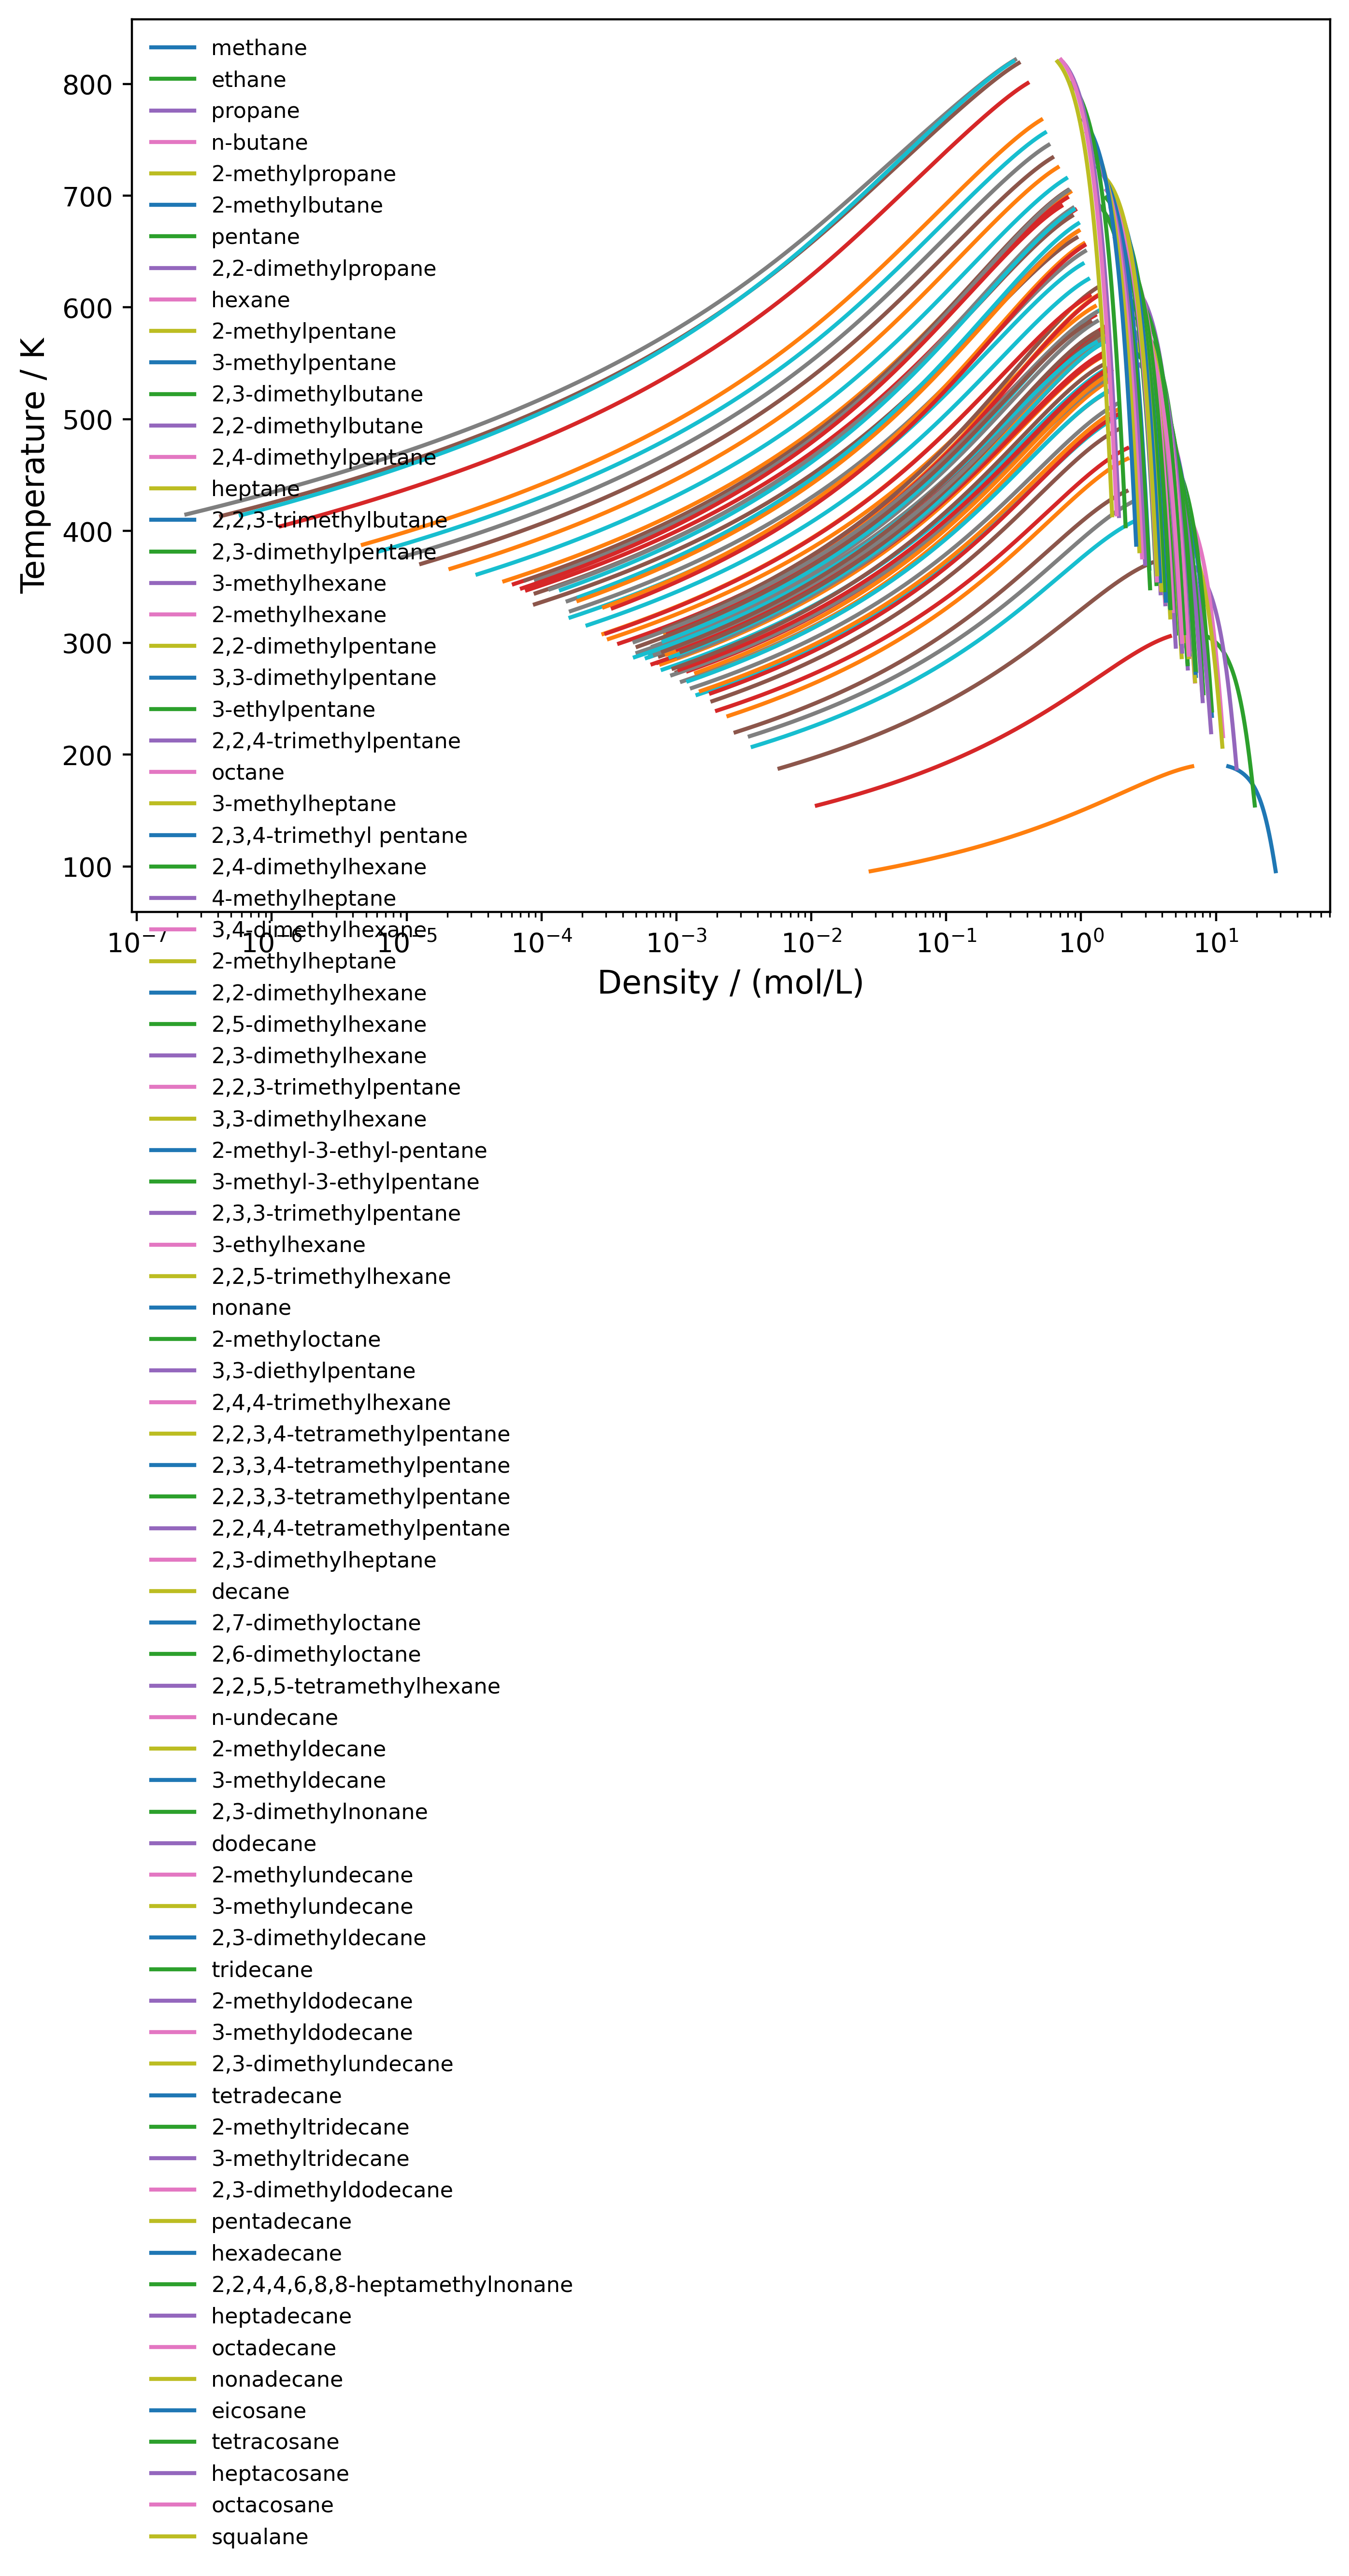

In [173]:
plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(critical_props)

plt.semilogx(1e-3 ./sat_vols_liq[i],temp_ranges[i],label=species_names[i])
plt.semilogx(1e-3 ./sat_vols_vap[i],temp_ranges[i])

end

plt.legend(loc="upper left",frameon=false,fontsize=8) 
plt.xlabel("Density / (mol/L)",fontsize=12)
plt.ylabel("Temperature / K",fontsize=12)

plt.savefig("alkane_envelopes.png",dpi=400)


In [ ]:
fieldnames(typeof(model))

println(model.sites)



SiteParam["methanol" => ["e" => 1, "H" => 1]]


In [ ]:
function make_model(Mw, m, σ, ϵ, λ_a, λ_r)
    model = PPCSAFT(["methane"])
    
    model.params.Mw[1] = Mw
    model.params.segment[1] = m
    model.params.sigma[1] = σ
    model.params.lambda_a[1] = λ_a
    model.params.lambda_r[1] = λ_r
    model.params.epsilon[1] = ϵ

    return model
end

make_model (generic function with 1 method)

In [ ]:
fieldnames(typeof(model6))
fieldnames(typeof(model6.params))
fieldnames(typeof(model6.params.epsilon_assoc.values))
typeof(model6.params.epsilon_assoc.values)

LoadError: UndefVarError: `model6` not defined

In [ ]:
model = PCSAFT(["methanol"],verbose=true)

[ Info: Searching for assocdata headers ["epsilon_assoc", "bondvol"] for query ["methanol"] at /home/mgadaloff/.julia/packages/Clapeyron/0fqKa/database/SAFT/PCSAFT/PCSAFT_assoc.csv ...
┌ Info: Found association component data: epsilon_assoc with values:
└  (methanol,H) ⇋ (methanol, e) => 2899.5
┌ Info: Found association component data: bondvol with values:
└  (methanol,H) ⇋ (methanol, e) => 0.035176
[ Info: Searching for singledata headers ["Mw", "segment", "sigma", "epsilon", "n_H", "n_e"] for query ["methanol"] at /home/mgadaloff/.julia/packages/Clapeyron/0fqKa/database/SAFT/PCSAFT/PCSAFT_like.csv ...
┌ Info: Found single component data: Mw with values:
└  methanol => 32.042
┌ Info: Found single component data: segment with values:
└  methanol => 1.5255
┌ Info: Found single component data: sigma with values:
└  methanol => 3.23
┌ Info: Found single component data: epsilon with values:
└  methanol => 188.9
┌ Info: Found single component data: n_H with values:
└  methanol => 1
┌ Info: 

PCSAFT{BasicIdeal, Float64} with 1 component:
 "methanol"
Contains parameters: Mw, segment, sigma, epsilon, epsilon_assoc, bondvol